# 1. 시계열 데이터 준비

In [1]:
# 모듈 임포트

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')



In [2]:
# 데이터 로드 및 시계열 생성

dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
df.head()





<class 'pandas.core.frame.DataFrame'>


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284


In [3]:
# 시리즈 객체로 변환

ts1 = df['Close']
print(type(ts1))
ts1.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

# 2. 데이터 전처리

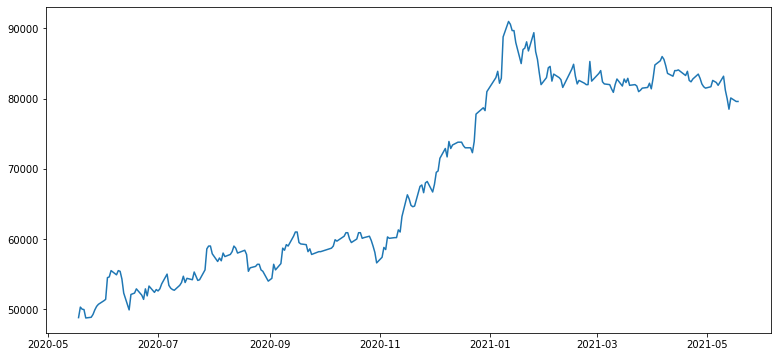

In [4]:
# 데이터 시각화 

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6
plt.plot(ts1)

In [5]:
# 결측치 확인

ts1[ts1.isna()]

Series([], Name: Close, dtype: float64)

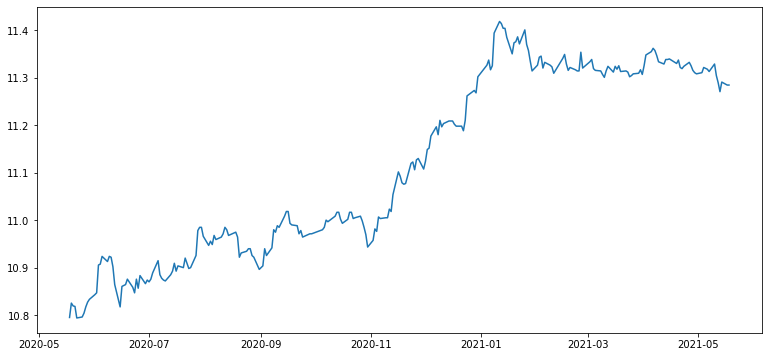

In [6]:
# 로그 함수 변환

ts_log = np.log(ts1)
plt.plot(ts_log)

# 3. 시계열 안정성 분석

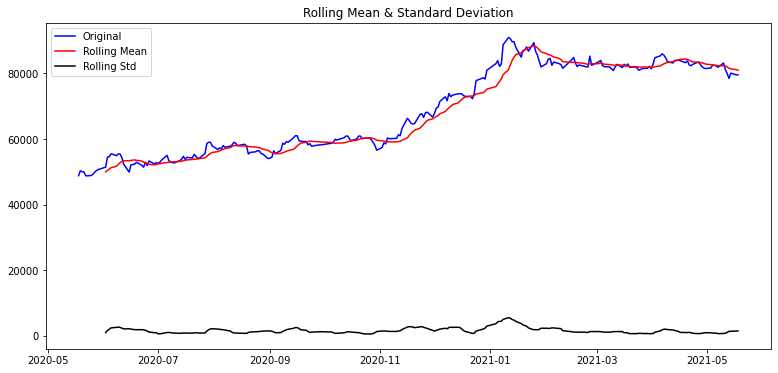

In [7]:
# 1. 정성적 분석 : 원본 시계열을 이동평균 및 이동 표준편차와 함꼐 시각화

    # 시각화 함수 생성
def plot_rolling_statistics(timeseries, window=12):
    
        # 이동평균
    rolmean = timeseries.rolling(window=window).mean()
    
        # 이동표준편차
    rolstd = timeseries.rolling(window=window).std()
    
        # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

    # 함수 실행
plot_rolling_statistics(ts1, window=12)

In [8]:
# 2. 정량적 분석 : Augmented Dickey-Fuller Test

    # Augmented Dickey-Fuller Test 함수 생성
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
        # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출
    dftest = adfuller(timeseries, autolag='AIC')
    
        # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    # DF test 실행
augmented_dickey_fuller_test(ts1)


Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


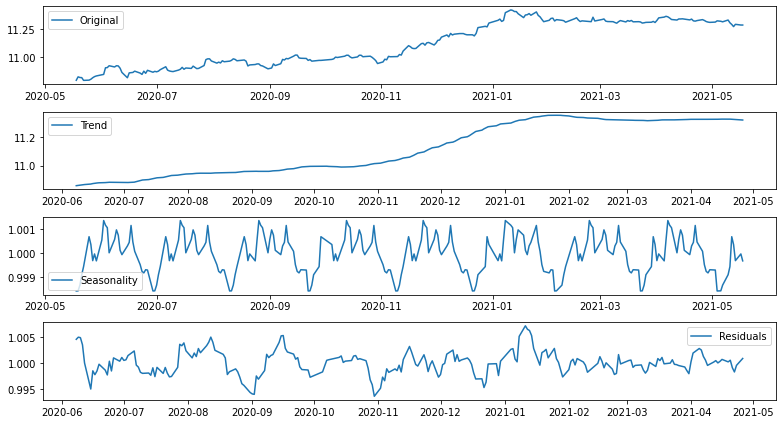

In [9]:
# 3. 시계열 분해(Time series decomposition)

from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period=30)

# 추세
trend = decomposition.trend
# 계절성
seasonal = decomposition.seasonal
# 원본(로그변환) - 추세 - 계절성
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

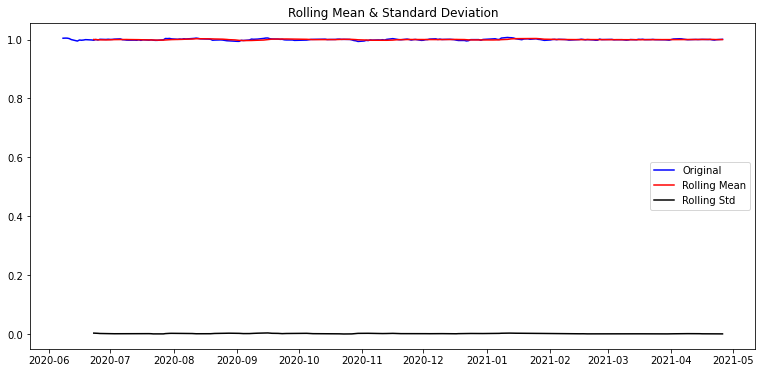

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


In [10]:
# Residual에 대한 안정성 확인

plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

# 4. 적정 ARIMA 모수 찾기

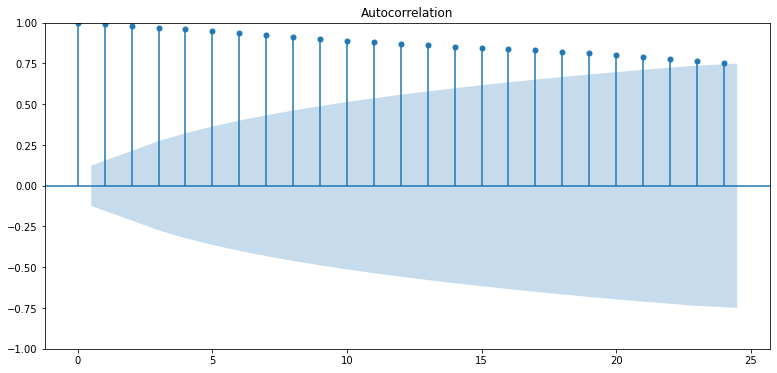

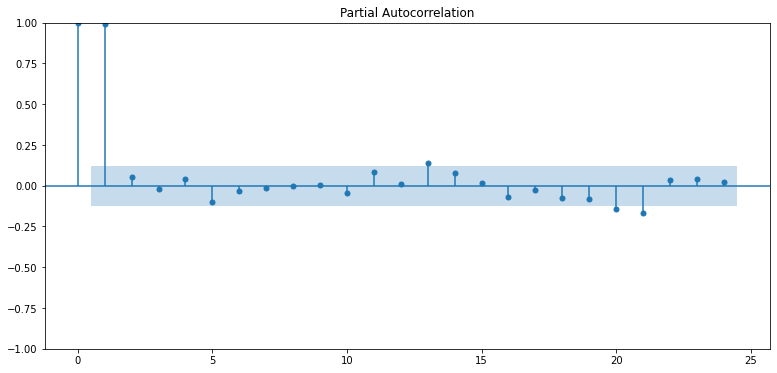

In [11]:
# ACF 및 PACF 그래프 그리기 -> p,q 구하기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


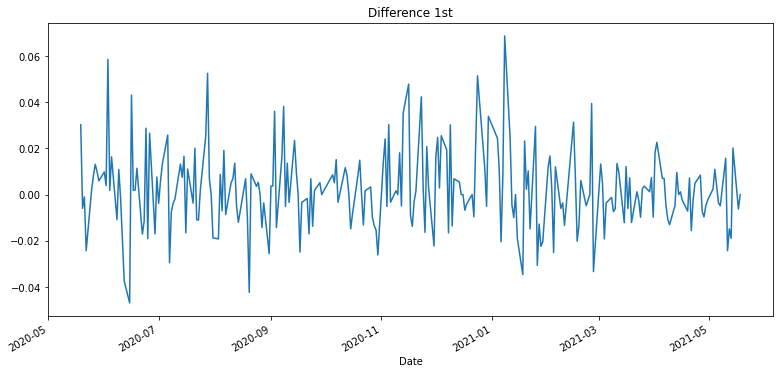

In [12]:
# 차분 안정성 확인 1 -> d구하기

    # 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


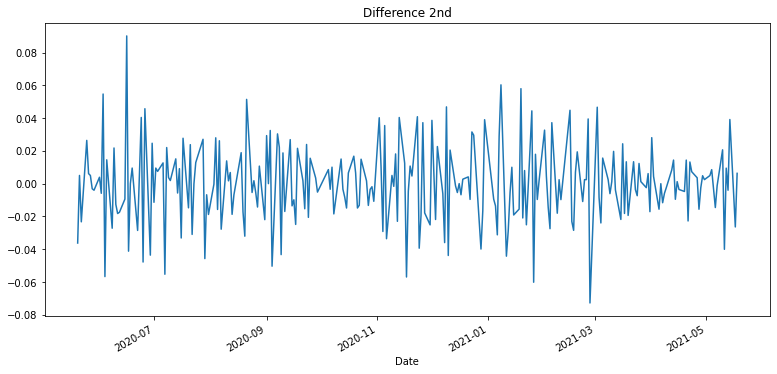

In [13]:
# 차분 안정성 확인 2 -> d구하기

    # 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

# 5. 학습, 테스트 데이터셋 분리

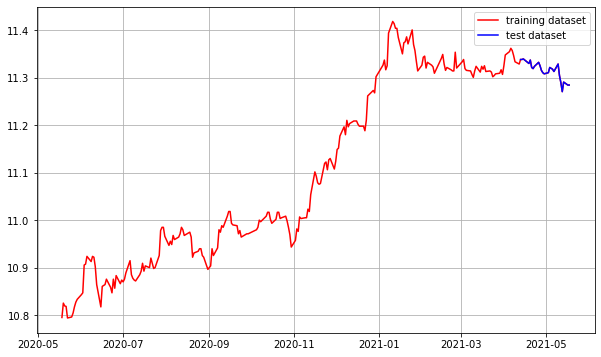

In [14]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)

    # training 데이터를 사용하면 데이터가 끊어져 보이므로 자연스럽게 보이기 위해 ts_log 사용
plt.plot(ts_log, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 6. ARIMA 모델  훈련과 테스트

In [15]:
# 모델 훈련

import warnings
warnings.filterwarnings('ignore')

    # 임포트 ARIMA
from statsmodels.tsa.arima.model import ARIMA

    # 모델 생성 (p=14, q=0, d=0)
model = ARIMA(train_data, order=(2, 0, 1) )
fitted_m = model.fit()

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 10 Feb 2022   AIC                          -1156.722
Time:                        09:18:44   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

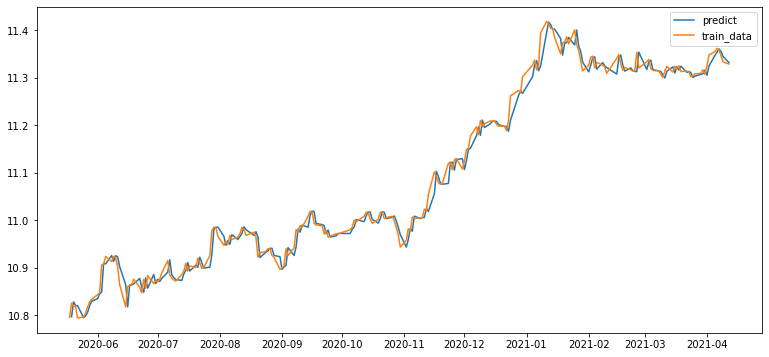

In [16]:
# 훈련 결과 시각화

fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

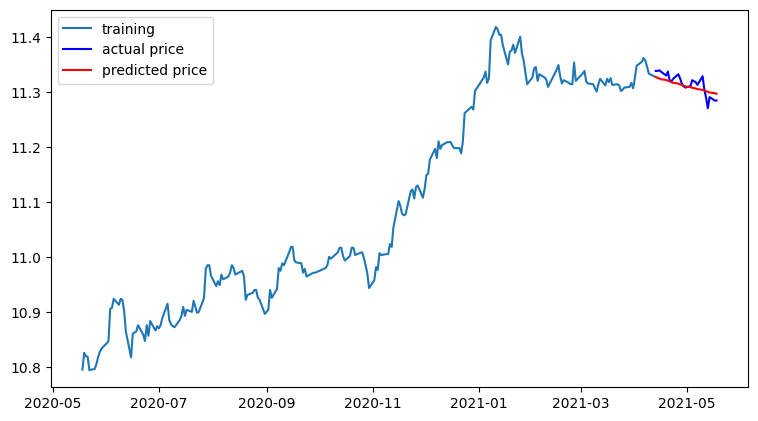

In [25]:
# 테스트 데이터 구간 예측

model = ARIMA(train_data, order=(2, 0, 1)) 
fitted_m = model.fit() 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [26]:
# 시계열 데이터 지수 변환 후 MSE, MAE, RMSE, MAPE 구하기

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))


MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


# 7. 다른 주식 종목 예측해보기

<class 'pandas.core.frame.DataFrame'>
                Open      High       Low     Close  Adj Close   Volume
Date                                                                  
2021-02-10   93200.0   98100.0   93200.0   97900.0    97900.0  9072415
2021-02-15   99800.0  101000.0   98400.0  100400.0   100400.0  5262740
2021-02-16  100800.0  103800.0   99900.0  102800.0   102800.0  5380240
2021-02-17  103000.0  103000.0  100600.0  101800.0   101800.0  2812860
2021-02-18  101200.0  103400.0  100200.0  100200.0   100200.0  2334610
<class 'pandas.core.series.Series'>
Date
2021-02-10     97900.0
2021-02-15    100400.0
2021-02-16    102800.0
2021-02-17    101800.0
2021-02-18    100200.0
Name: Close, dtype: float64


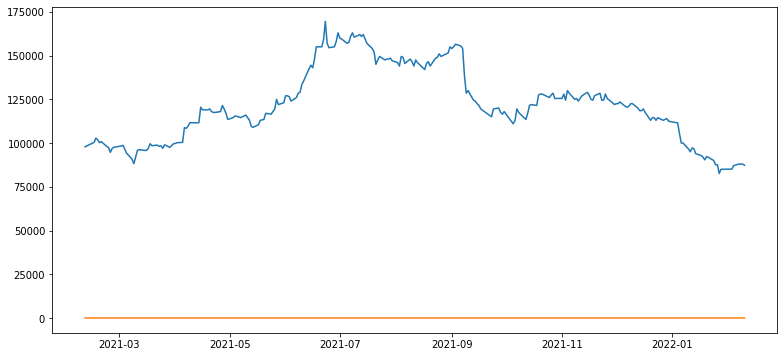

In [27]:
# 모듈 임포트

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import warnings
warnings.filterwarnings('ignore')

# 데이터 전처리
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/035720.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
print(type(df))
print(df.head())

ts2 = df['Close']
print(type(ts2))
print(ts2.head())

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6
plt.plot(ts2)

ts2[ts2.isna()]

ts_log2 = np.log(ts2)
plt.plot(ts_log2)

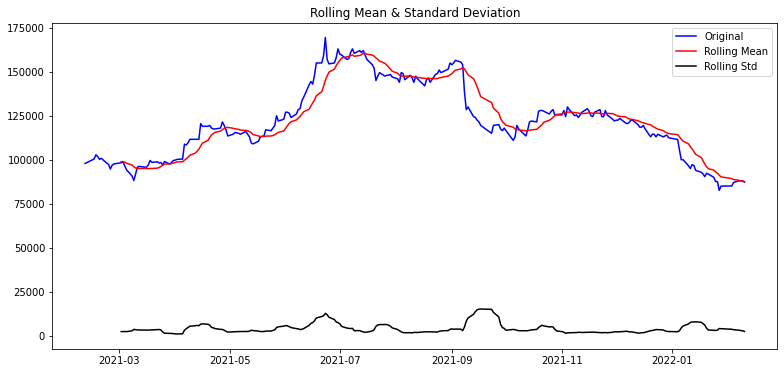

None
Results of Dickey-Fuller Test:
Test Statistic                  -0.930802
p-value                          0.777660
#Lags Used                       3.000000
Number of Observations Used    242.000000
Critical Value (1%)             -3.457664
Critical Value (5%)             -2.873559
Critical Value (10%)            -2.573175
dtype: float64


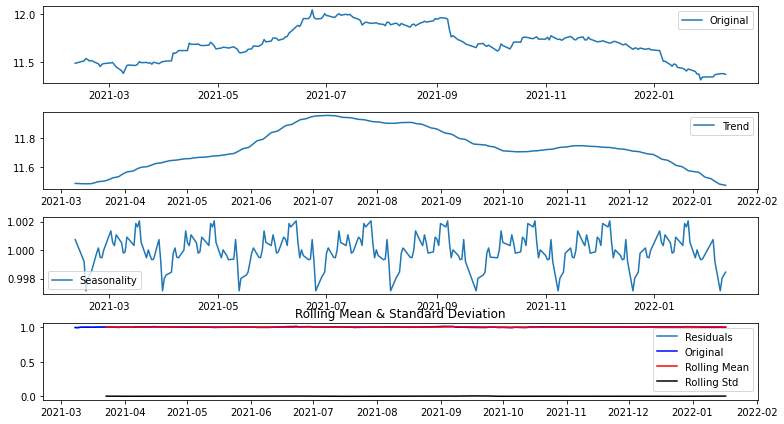

Results of Dickey-Fuller Test:
Test Statistic                  -4.559578
p-value                          0.000153
#Lags Used                       5.000000
Number of Observations Used    210.000000
Critical Value (1%)             -3.461879
Critical Value (5%)             -2.875404
Critical Value (10%)            -2.574159
dtype: float64


In [28]:
# 시계열 안정성 분석

print(plot_rolling_statistics(ts2, window=12))



augmented_dickey_fuller_test(ts2)



from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log2, model='multiplicative', period=30)

# 추세
trend = decomposition.trend
# 계절성
seasonal = decomposition.seasonal
# 원본(로그변환) - 추세 - 계절성
residual = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log2, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

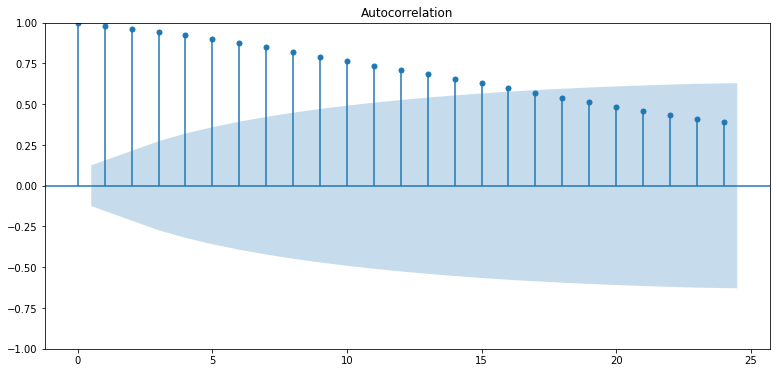

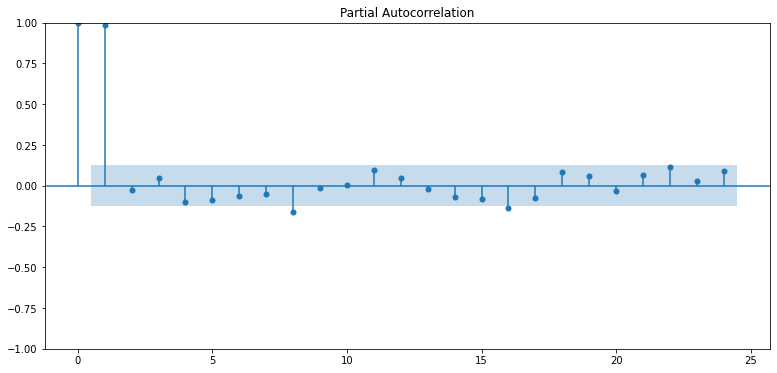

Results of Dickey-Fuller Test:
Test Statistic                -7.888119e+00
p-value                        4.512048e-12
#Lags Used                     2.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.070970e+01
p-value                        3.356490e-19
#Lags Used                     6.000000e+00
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


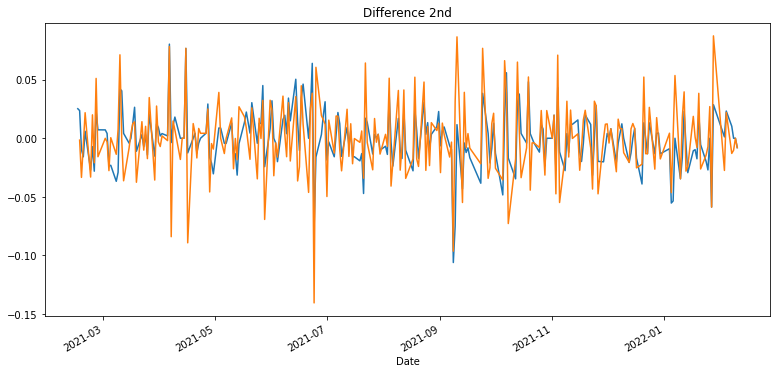

In [29]:
# 적정 ARIMA 모수 찾기

    # ACF 및 PACF 그래프 그리기 -> p,q 구하기

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log2)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log2)
plt.show()


    # 차분 안정성 확인 1 -> d구하기

    # 1차 차분 구하기
diff_1 = ts_log2.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)



    # 차분 안정성 확인 2 -> d구하기

    # 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

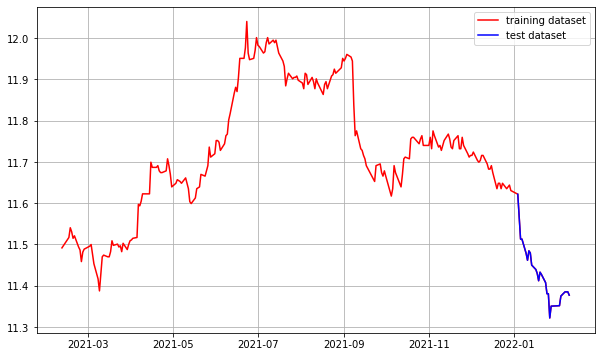

In [30]:
# 학습, 테스트 데이터셋 분리

train_data, test_data = ts_log2[:int(len(ts_log2)*0.9)], ts_log2[int(len(ts_log2)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)

    # training 데이터를 사용하면 데이터가 끊어져 보이므로 자연스럽게 보이기 위해 ts_log2 사용
plt.plot(ts_log2, c='r', label='training dataset')
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(2, 0, 1)   Log Likelihood                 583.361
Date:                Thu, 10 Feb 2022   AIC                          -1156.722
Time:                        09:19:23   BIC                          -1139.642
Sample:                             0   HQIC                         -1149.828
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.129     86.277      0.000      10.838      11.342
ar.L1          0.7739      1.821      0.425      0.671      -2.796       4.344
ar.L2          0.2191      1.811      0.121      0.9

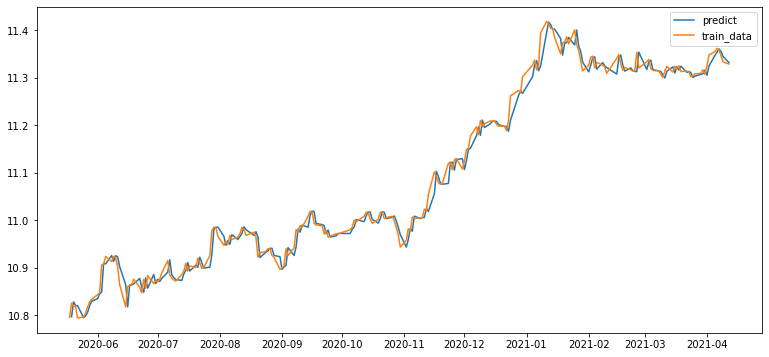

In [21]:
# ARIMA 모델 훈련과 테스트


# 모델 훈련

import warnings
warnings.filterwarnings('ignore')

    # 임포트 ARIMA
from statsmodels.tsa.arima.model import ARIMA

    # 모델 생성 (p=14, q=0, d=0)
model = ARIMA(train_data, order=(2, 0, 1) )
fitted_m = model.fit()

print(fitted_m.summary())


# 훈련 결과 시각화

fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()


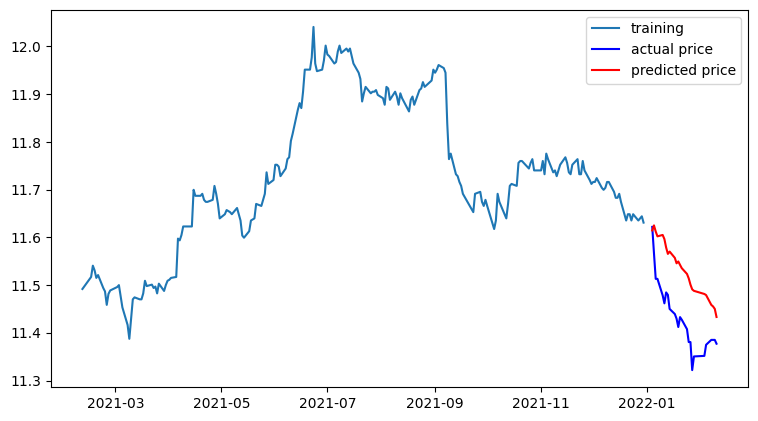

In [67]:
# 테스트 데이터 구간 예측

model = ARIMA(train_data, order=(50, 3, 3)) 
fitted_m = model.fit() 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()
